In [2]:
import cv2 as cv
import numpy as np
import sklearn as skl
import scipy as cp
import matplotlib.pyplot as plt
import tensorflow as tf
import torch as pt
import os
import csv
import sys
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import manifold, neighbors, metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from joblib import dump, load
from sklearn.decomposition import PCA


In [3]:
### Dictionaries for labeling data from images
def retrieveDict(nr):
    if nr == 0:
        dictionary = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26}
    elif nr == 1:
        dictionary = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}
    else:
        print("No valid dictionary found")
        dictionary = -1
    
    return dictionary

In [4]:
### Data reading functions

def readDataFolder(path, dictionary, oneHot,rescaleSize):
    '''read data from different folders
        data location: .../path/
        labels assigned from dictionary default A = 1, B = 2 etc
        oneHot determines if labels are made binary i.e. A =[1,0,...], B=[0,1,...] etc
        returns data, rescaled to rescaleSize,rescaleSize and labels as numpy arrays
        '''
    data = []
    labels = []
    size = rescaleSize,rescaleSize
    #folder ='A'
    for folder in os.listdir(path):
        print(folder, end = ' | ')
        for image in os.listdir(path + "/" + folder):
            img = cv.imread(path + os.sep + folder + os.sep + image)
            img = cv.resize(img,size)
            data.append(img)
            labels.append(dictionary[folder])
    data = np.array(data)
    data = data.astype('float32')/255.0

    
    labels = np.array(labels)
    
    return data, labels

def readCSV(path, rescaleSize):
    '''read data from csv file
        data location: .../path/
        returns data, rescaled to rescaleSize,rescaleSize, and labels as numpy arrays
        '''
    size = rescaleSize,rescaleSize
    data = []
    train = pd.read_csv(path)
    labels = train['label'].values
    unique_val = np.array(labels)
    np.unique(unique_val)
    
    train.drop('label', axis = 1, inplace = True)
    images = train.values
 
    for i in range(len(images)):
        img = images[i].reshape(28,28)
        img = cv.resize(img.astype('uint8'),size)
        data.append(img)
    data = np.array(data)
    data = data.astype('float32')/255.0
    
    return data, labels

In [5]:
### Different PreProcessing methods

def preprocessing(method, data, size, parameters, dataset):
    '''
        Applies preprocessing to data
            
        '''
    # Parameters
    gaussianKernel = parameters[0]
    gaussianMean = parameters[1]
    structElement = np.ones((parameters[2],parameters[2]),np.uint8)
    cannyKernel = parameters[3]
    lowThreshold = parameters[4]
    highThreshold = parameters[5]
    
    if method[0] == 1:
        print("Not implemented, Doing Gamma Correction")
                       
    if method[1] == 1:
        print("Gaussian Denoising")
        data = gaussianDenoise(data, gaussianKernel, gaussianMean, size)
        
    if method[2] == 1:
        print("Converting to grayscale")
        data = grayscale(data)
        
    if method[3] == 1:
        print("Canny Edge detection")
        data = cannyEdgeDetection(data,lowThreshold,highThreshold,cannyKernel)
        
    if method[4] == 1:
        print("Segmentation, background/foreground")     
        data = segmentation(data,structElement, method[2], dataset)
        
    if method[5] == 1:
        print("Sobel Filtering")
        data = sobelFilter(data)
        
    if method[6] == 1:
        print("Performing opening")
        data = opening(data,structElement)
    return data

def cannyEdgeDetection(inData, lowThreshold,highThreshold, kernelSize):
    data = []
    for i in range(len(inData)):
        cannyEdges = cv.Canny(inData[i].astype("uint8"), lowThreshold, highThreshold, kernelSize)
        data.append(cannyEdges)

    data = np.array(data)
    return data
  
def grayscale(inData):
    data = []
    for i in range(len(inData)):
        gray = cv.cvtColor(inData[i]*255, cv.COLOR_RGB2GRAY).astype("uint8") #Convert to grayscale
        data.append(gray)
    data = np.array(data)
    return data

        
def gaussianDenoise(inData, kernel, mu, size):
    data = []
    for i in range(len(inData)):
        blurred = cv.GaussianBlur(inData[i], (kernel,kernel),mu)
        data.append(blurred)
    data = np.array(data)
    return data
        
def adjustGamma(image, gamma = 1.0): # Try to implement to get working for images
    invGamma = 1/gamma
    table = np.array([((i/255.0)**invGamma)*255
        for i in np.arange(0,256)]).astype("uint8")
    return cv.LUT(image,table)

def segmentation(inData,structElement,grayed,dataset):
    data = []
    for i in range(len(inData)): 
        if grayed == 0 and dataset != 2: 
            gray = cv.cvtColor(inData[i]*255, cv.COLOR_RGB2GRAY).astype("uint8") #Convert to grayscale
        elif grayed == 1 or dataset == 2:
            gray = inData[i]
            
        thresholding1 = cv.adaptiveThreshold(gray.astype('uint8'),255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2) #perform adaptive thresholing
        opening = cv.morphologyEx(thresholding1 , cv.MORPH_OPEN, structElement, iterations=2) #perform opening
        distance_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
        data.append(distance_transform)
    data = np.array(data)
    return data

def opening(inData,structElement):
    data = []
    for i in range(len(inData)):
        opening = cv.morphologyEx(inData[i] , cv.MORPH_OPEN, structElement, iterations=2) #perform opening
        data.append(opening)
    data = np.array(data)
    return data

def sobelFilter(inData):
    data = []
    for i in range(len(inData)):
        sobel = cv.Sobel(inData[i],cv.CV_64F,0,1,ksize=3)
        data.append(sobel)
    data = np.array(data)
    return data

def splitData(data, labels, testSize, binaryLabel, pca):
    
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, stratify = labels, random_state = 7)
    
    if binaryLabel == 1: #Need to binarize data after splitting, if data is binarized QDA and LDA won't work
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
    
    if pca == 1:
        print("Performing PCA")
        pca = PCA(0.95)
        pca.fit(x_train)
        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
        
    return x_train, x_test, y_train, y_test

In [6]:
### Visualize things

def plotSamples(data, samples, size):
    fig, axs = plt.subplots(1, samples, figsize=(15, 4), sharey=True)
    if len(np.shape(data)) == 4:
        for i in range(samples): 
            axs[i].imshow(data[i])
    else:
        for i in range(samples): 
            axs[i].imshow(data[np.random.randint(len(data),size = 1)].reshape(size,size))

In [7]:
### Data Augmentation

def augmentData(data, labels, parameters, methods):
    runs = parameters[0] #Nr of times to multiply data i.e. 1 leads to twice the original data 2=3 times etc.
    strength = parameters[1] #Strength of gaussian noise
    maxDegree = parameters[2] #Maximum degree to rotate image
    size = parameters[3]
    labelToAppend = labels
    
    if methods[1] == 1:
        augmentedData = data.reshape(len(data),size,size) #Rotate requires shape of (a,b,c)
        origData = data.reshape(len(data),size,size)
    else:
        augmentedData = data
        origData = data
    dataLength = len(data)

    for i in range(runs):
        for j in range(dataLength):
            if methods[0] == 1:
                augmentedData[j] = randomNoise(origData[j],strength)
            if methods[1] == 1:
                augmentedData[j] = rotate(origData[j],maxDegree)
            if methods[2] == 1:
                augmentedData[j] = flip(origData[j])
        labels = np.hstack((labels,labelToAppend)) #Extend labels since we don't want to change them at all
        origData = np.vstack((origData, augmentedData))
    data = origData.reshape(-1,(size*size))
    ## Shuffle data at end
    return data, labels

def randomNoise(data, strength):
    """
    Subtract gaussian white noise from data
        :param Data to subtract from, strength of noise
        :return: Data where noise have been subtracted
        """
    randNoise = np.random.rand()
    if randNoise < 0.5:
        data = np.subtract(data,np.random.normal(0, strength, size=np.shape(data))) # Subtract noise
    else:
        data = np.add(data,np.random.normal(0, strength, size=np.shape(data))) # Subtract noise

    return data

def rotate(data, maxAngle): #To be written
    
    center = (64 / 2, 64 / 2)
    angle = np.random.uniform(0,maxAngle,1)
    direction = np.random.rand()
    if direction < 0.5:
        angle = -angle
    rotationMatrix = cv.getRotationMatrix2D(center,angle,1.0)
    data = cv.warpAffine(data, rotationMatrix, (64,64))
    return data

def flip(data): 
    axis = np.random.randint(3,size = 1)
    if axis == 0:
        data = cv.flip(data, 0) #Vertical
    elif axis == 1:
        data = cv.flip(data,1) #Horizontal
    else:
        data = cv.flip(data,-1) #Horizontal and vertical
    return data

In [8]:
### Different non deep learning classifiers

def trainNonDeepLearning(models, modelParameters, data, labels):
    '''
    Train a selection of models and return them
    '''
    randomForestDepth = modelParameters[0]
    trainedModels = []
    if models[0] == 1:
        model = decisionTree(data, labels)
    elif models[1] == 1:
        model = randomForest(data, labels, randomForestDepth)
    elif models[2] == 1:
        model = knn(data, labels)
    elif models[3] == 1: 
        model = qda(data, labels)
    elif models[4] == 1:
        model = lda(data, labels)
    elif models[5] == 1:
        model = svm(data, labels)
    
    return model

def decisionTree(data, labels):
    '''
    Decision tree classifier
    '''
    model = tree.DecisionTreeClassifier()#Create model
    print("Fitting data to decision tree.")
    model.fit(data,labels) #Train model
    dump(model, 'decisionTree.joblib')

    return model

def randomForest(data, labels, depth):
    '''
    Random forest classifier
    '''
    model = RandomForestClassifier(max_depth = depth)#Create model
    print("Fitting data to random forest.")
    model.fit(data,labels) #Train model
    dump(model, 'randomForest.joblib')

    return model

def knn(data, labels): #Try to change neighbors to not be hardcoded in function call
    '''
    k-nearet neighbors classifier
    '''
    model = neighbors.KNeighborsClassifier(10, weights='distance')
    print("Fitting data to K-NN model")
    model.fit(data, labels)
    dump(model, 'knn.joblib')
    return model

def qda(data, labels):
    """
    Trains a qda model from data and labels
        :param data and labels to train with
        :return: trained qda model
        """
    model = QuadraticDiscriminantAnalysis() #Create classifier
    print("Fitting data to quadratic discriminant model")
    model.fit(data, labels) # train classifier
    dump(model, 'qda.joblib')
    return model

def lda(data, labels):
    """
        Trains a lda model from data and labels
            :param data and labels to train with
            :return: trained lda model
            """
    model = LinearDiscriminantAnalysis() #Create model
    print("Fitting data to linear discriminant model")
    model.fit(data,labels) #Train model
    dump(model, 'lda.joblib')
    return model

def svm(data,labels):
    """
        Trains a svm model from data and labels
            :param data and labels to train with
            :return: trained svm model
            """
    model = LinearSVC(max_iter= 100000) #Increase to help with badly conditioned data
    model = CalibratedClassifierCV(model)
    print("Fitting data to support vector")
    model.fit(data,labels) #Train svm classifier
    dump(model, 'SVM.joblib')
    return model

In [9]:
### Evaluation methods

def evaluateSKlearn(model, data, labels, kfold, visualize):
    print("Evaluation model.")
    prediction = model.predict(data)
    accuracy = metrics.accuracy_score(labels,prediction)
    
    print("\n Accuracy: %f",accuracy)
    print("\n Results from classifier:  \n %s \n" %( metrics.classification_report(labels, prediction)))
    if visualize == 1: #Since confusion matrix takes a lot of space
        print("\n Confussion matrix:\n %s" % metrics.confusion_matrix(labels, prediction)) #Print confusion matrix

        
    #Perform kfold cross validation
    scores = cross_val_score(model, data, labels, cv=kfold) #Do cross validation
    print("\n Cross validation score: \n")
    print(scores) #Report scores of cross validation
    print("\n Mean cv score: %f", np.mean(scores))


In [10]:
### CNN Architectures

# From paper Using Deep Convolutional Networks for Gesture Recognition in American Sign Language

def bhedamNet(size,channels,classes,opti):
    '''
    Number of filters for each layer are not specified in paper 
    
    '''
    inputDim = (size,size,channels)

    model = Sequential()
    model.add(Conv2D(64, kernel_size = (3,3), activation='relu', input_shape= inputDim)) #Input layer 
    model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same'))
    model.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, kernel_size = (3,3), activation='relu', padding = 'same'))
    model.add(Conv2D(16, kernel_size = (3,3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
        
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))   
        
    model.add(Dense(classes, activation = 'softmax')) #Output layer

    model.compile(optimizer = opti, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model
    
# From a kaggle user
def kaggleNet(size,channels, classes, opti):
    
    inputDim = (size,size,channels)

    model = Sequential()
    
    model.add(Conv2D(64, kernel_size = 4, strides = 1, activation = 'relu', input_shape=inputDim)) #input layer
    model.add(Conv2D(64, kernel_size = 4, strides = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size = 4, strides = 1, activation = 'relu'))
    model.add(Conv2D(128, kernel_size = 4, strides = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, kernel_size = 4, strides = 1, activation = 'relu'))
    model.add(Conv2D(256, kernel_size = 4, strides = 2, activation = 'relu'))
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(classes, activation = 'softmax')) #output layer

    model.compile(optimizer = opti, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
        
# From paper Recognition Bangla Sign Language using Convolutional Neural Network
def islalmNet(size,channels, classes, opti):
    inputDim = (size,size,channels)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (5,5), padding = 'same', input_shape= inputDim))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))

    model.add(Conv2D(64, kernel_size = (5,5), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))
    
    model.add(Conv2D(384, kernel_size = (3,3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))
    
    model.add(Conv2D(512, kernel_size = (3,3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size(2,2)))
    
    model.add(AveragePooling2D(2,2))
    model.add(Dense(84, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation ='softmax'))
    
    model.compile(optimizer = opti, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model
    

In [11]:
### Train and test neural network
def trainCNN(size, data, labels, architecture, parameter):
    '''
    Train a cnn using one of three architectures 
    '''
    channels = np.shape(data)[3]
    
    callback = [EarlyStopping(monitor='val_loss', patience=parameter[0]), 
                ModelCheckpoint(filepath='BestModel.hdf5', monitor='val_loss', save_best_only=True)] #Set up callback, early stopping regularisation
    
    classes = np.amax(labels)+1

    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #Set up Adam optimiser
            
    trainingData, validationData, trainingLabels, validationLabels = train_test_split(data, labels, test_size = 0.3, stratify = labels, random_state = 7)

    if architecture[0] == 1:
        model = bhedamNet(size, channels, classes, optimizer)
    elif architecture[1] == 1:
        model = kaggleNet(size, channels, classes, optimizer)
    elif architecture[2] == 1:
        model = islalmNet(size, channels, classes, optimizer)
        
    if parameter[3] == 1:
        print("Using real-time data augmentation")
        augmentation = ImageDataGenerator(
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                        shear_range = 0.1,  # set range for random shear
                        zoom_range = 0.1,  # set range for random zoom
                        fill_mode = 'nearest', # set mode for filling points outside the input boundaries
                        cval=0.,  # value used for fill_mode = "constant"
                        horizontal_flip=True,  # randomly flip images
                        vertical_flip=True,  # randomly flip images
                        rescale=None,       # set rescaling factor (applied before any other transformation)
                        validation_split = 0.1)  # fraction of images reserved for validation (strictly between 0 and 1)
        augmentation.fit(trainingData)
        trainedModel = model.fit(augmentation.flow(trainingData, trainingLabels, batch_size = parameter[1]),
                                    epochs = parameter[2], callbacks=callback, verbose = 1, 
                                    validation_data =(validationData, validationLabels))
        trainedModel = load_model('BestModel.hdf5')
    
    else:
        print("Not using data augmentation")   
        trainedModel = model.fit(trainingData, trainingLabels, batch_size = parameter[1], 
                                 epochs = parameter[2], callbacks=callback, verbose = 1, 
                                 validation_data=(validationData, validationLabels), shuffle = True) 
        
        trainedModel = load_model('BestModel.hdf5')
    
    return trainedModel

def evaluateCNN(testData,testLabels, model):
    print("Evaluation network.")
    scores = model.evaluate(testData, testLabels, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    

In [12]:
### Read data
dataset = 0 # 0 for significant ASL, 1 for ASL dataset, 2 for MNIST dataset
currentLocation = os.getcwd()
rescaleSize = 64 # rescale images to size rescaleSize,rescaleSize 
binaryLabel = 0 # 0 for encoded i.e. A=1, B=2 etc 1 to one hot encode data i.e. A =[1,0,...], B = [0,1,...] etc

## Load data
if dataset == 0:
    path = currentLocation + os.sep +'significant-asl-sign-language-alphabet-dataset' + os.sep + 'Training-Set'
elif dataset == 1:
    path = currentLocation + os.sep + 'asl-alphabet' + os.sep + 'asl_alphabet_train'  # + os.sep + 'asl_alphabet_train' 
elif dataset == 2:
    path = currentLocation + os.sep + 'data' + os.sep + 'sign_mnist_train.csv' 
else:
    print('Invalid dataset')
    sys.exit()

dictionary = retrieveDict(dataset)
print('Reading data.')
if dataset == 0 or dataset ==  1:
    data, labels = readDataFolder(path, dictionary, binaryLabel, rescaleSize)
elif dataset == 2:
    data, labels = readCSV(path, rescaleSize)


Reading data.
A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | space | T | U | V | W | X | Y | Z | 

In [12]:
#### Main code
##Parameters
visualize = 0 # if showing images 
testSize = 0.3 #Percentage of training data kept for testing
deepLearning = 0 # 0 for non deep learning methods 1 for CNN

## preprocess methods
pca = 0 # 1 to do pca, 0 to not do. if doing other preprocessing and augmentation is turned of
gammaCorrection = 0 # Do gamma correction to move average pixel intesity to range 100-150 Not implemented yet
gaussianBlur = 1 # If we apply gaussian blur to images
grayScale = 0 #Convert to grayscale automatically done if using segmentation
edgeDetection = 0 # If we do edge detection, using canny edge detector
Segmentation = 0 # Try to segment image into foreground and background 
sobel = 0 # Try to segment image into different objects
opening = 0 # Do morphological opening, erosion followed by dilation

# preprocessing parameters
gaussianKernel = 5 #Size of gaussian kernel low pass filter
gaussianMean = 0 #Mean of gaussian low pass filter
structElementKernel = 3 #Size of structuring element used in opening, erosion etc. 
cannyKernel = 3 #Kernel for canny edge detection
lowThreshold = 40 #Low threshold for canny edge detection
highThreshold = 120 #High threshold for canny edge detection

## non deep learning classifiers, can only train one model at a time
decissionTree = 0
crandomForest = 1
randomForestMaxDepth = 12
kNearestNeighbor = 0
quadraticDiscriminantAnalysis = 0
linearDiscriminantAnalysis = 0
supportVectorClassification = 0 #Slow training

# non deep learning data augmentation parameters and methods
nonDLAugment = 0 #0 to not augment data, 1 to augment
aRuns = 2 #Nr of times to multiply data i.e. 1 leads to twice the original data 2=3 times etc.

aNoise = 1 #apply gaussian noise
aRotate = 1 # rotate image
aFlip = 1 #flip image, horizontaly and vertically

aStrength = 0.01 #Strength of gaussian noise
aMaxDegree = 90 #Maximum degree to rotate image

kfold = 4 #folds for k-fold cross validation used for non deep learning only

# cnn architectures
bheda = 1 # network from paper "Using Deep Convolutional Networks for Gesture Recognition in American Sign Language"
kaggle = 0 # network from a kaggle notebook
islalm = 0 # network from  paper "Recognition Bangla Sign Language using Convolutional Neural Network"

# deep learning parameters
earlyStoppingPatience = 20 #patience for early stoping i.e how long to continue without increase in accuracy
BATCH_SIZE = 32
EPOCHS = 100
cAugmentation = 0 # 0 to not augment data, 1 to augment

if deepLearning == 0:
    classifiers = []
    classifiers.append(decissionTree)
    classifiers.append(crandomForest)
    classifiers.append(kNearestNeighbor)
    classifiers.append(quadraticDiscriminantAnalysis)
    classifiers.append(linearDiscriminantAnalysis)
    classifiers.append(supportVectorClassification)
    if sum(classifiers) != 1:
        print("Incorrect number of classifiers selected, program supports training 1 classifier at a time.")
        sys.exit()
    aParameter = []
    aParameter.append(aRuns)
    aParameter.append(aStrength)
    aParameter.append(aMaxDegree)
    aParameter.append(rescaleSize)

    aMethods =[]
    aMethods.append(aNoise)
    aMethods.append(aRotate)
    aMethods.append(aFlip)

    #non deep learning classifier parameters
    classifierParameters = []
    classifierParameters.append(randomForestMaxDepth) 

if pca == 1:
    deepLearning = 0
    
if deepLearning == 1:

    cArchitecture = []
    cArchitecture.append(bheda)
    cArchitecture.append(kaggle)
    cArchitecture.append(islalm) 
    if sum(cArchitecture) != 1:
        print("Warning: Train one network at a time.")
        sys.exit()
    cParameter = []
    cParameter.append(earlyStoppingPatience)
    cParameter.append(BATCH_SIZE)
    cParameter.append(EPOCHS)
    cParameter.append(cAugmentation)

if dataset == 2:
    grayScale = 0 #don't try to convert grayscale image to grayscale

preprocessingParameters = []
preprocessingParameters.append(gaussianKernel)
preprocessingParameters.append(gaussianMean)
preprocessingParameters.append(structElementKernel)
preprocessingParameters.append(cannyKernel)
preprocessingParameters.append(lowThreshold)
preprocessingParameters.append(highThreshold)

methods = []
methods.append(gammaCorrection)
methods.append(gaussianBlur)
methods.append(grayScale)
methods.append(edgeDetection)
methods.append(Segmentation)
methods.append(sobel)
methods.append(opening)



# Visualize some samples of data
if visualize == 1:
    print('Visualize 5 samples from data.')
    plotSamples(data,5,rescaleSize)
print(np.shape(data))
## Preprocessing
preprocessedData = preprocessing(methods, data, rescaleSize, preprocessingParameters, dataset)
print(np.shape(preprocessedData))

if deepLearning == 0: #From here and down is specific things for non deep learning classification
    if binaryLabel == 1 and (quadraticDiscriminantAnalysis == 1 or linearDiscriminantAnalysis ==1):
        print("Warning: QDA and LDA does not work with binary labels setting labels to non binary")
        binaryLabel = 0

    ## Reshape data into size(nr_samples,features) 
    if len(np.shape(preprocessedData)) == 4:
        preprocessedData = grayscale(preprocessedData.astype("float32"))
        preprocessedData = preprocessedData.reshape(-1,(rescaleSize*rescaleSize))  
    else:
        preprocessedData = preprocessedData.reshape(-1,(rescaleSize*rescaleSize))  

    # Split data into train and test data and convert labels to binary if desired
    trainData, testData, trainLabel, testLabel = splitData(preprocessedData, labels, testSize, binaryLabel, pca)
    
    # augment data if desired
    if nonDLAugment == 1:
        trainData, trainLabel = augmentData(trainData, trainLabel, aParameter, aMethods)
    print(np.sum(trainData[0]))
    ## Train and evaluate non deep learning model
    model = trainNonDeepLearning(classifiers, classifierParameters, trainData, trainLabel)
    evaluateSKlearn(model,testData,testLabel, kfold, visualize)

if deepLearning == 1:
    if len(np.shape(preprocessedData)) < 4: #grayscale/binary might come in shape (samples x size x size), but we need (samples x size x size x channels)
        preprocessedData = preprocessedData[..., np.newaxis]
    
    trainData, testData, trainLabel, testLabel = splitData(preprocessedData, labels, testSize, binaryLabel, pca) #not sure if binary labels work with the dimensions
    
    network = trainCNN(rescaleSize, trainData, trainLabel, cArchitecture, cParameter)

    evaluateCNN(testData, testLabel, network)


(77490, 64, 64, 3)
Gaussian Denoising
(77490, 64, 64, 3)
257893
Fitting data to random forest.
Evaluation model.

 Accuracy: %f 0.8897922312556459

 Results from classifier:  
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       893
           1       0.94      0.91      0.92       905
           2       0.95      0.92      0.94       976
           3       0.88      0.86      0.87       895
           4       0.95      0.88      0.91       871
           5       0.89      0.93      0.91       833
           6       0.94      0.87      0.91       880
           7       0.90      0.92      0.91       882
           8       0.92      0.87      0.89       878
           9       1.00      0.67      0.80         9
          10       0.80      0.88      0.84       938
          11       0.89      0.92      0.91       917
          12       0.92      0.90      0.91       845
          13       0.92      0.84      0.88       833
          14

In [22]:
import itertools
prediction = model.predict(testData)
accuracy = metrics.accuracy_score(testLabel,prediction)
target_names =['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','Space','T','U','V','W','X','Y','Z']

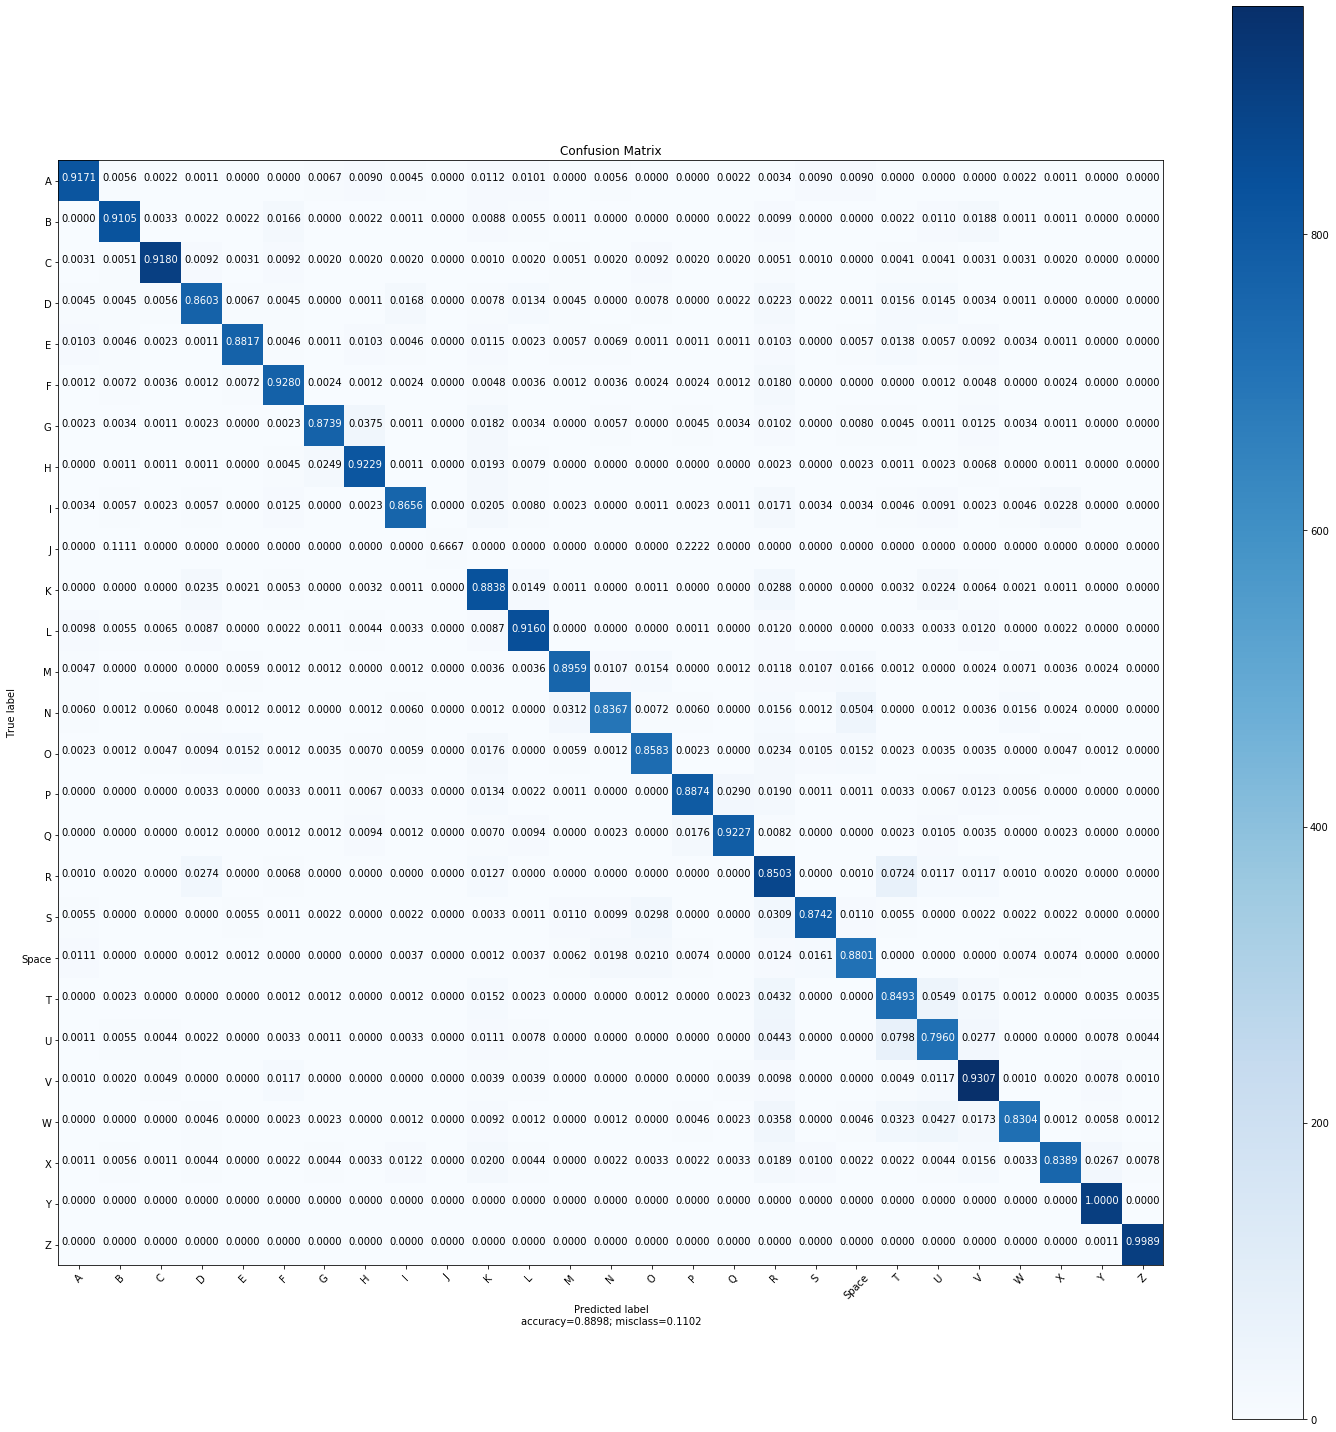

In [27]:
cm = metrics.confusion_matrix(testLabel, prediction)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')
plt.figure(figsize=(20, 20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 1.5 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show()

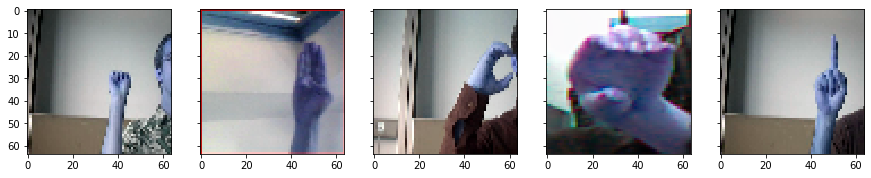

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
if len(np.shape(data)) == 4:
    for i in range(5): 
        axs[i].imshow(data[i*3000])
else:
    for i in range(5): 
        axs[i].imshow(data[i+3000].reshape(size,size))